In [1]:
from slim_gsgp_lib.main_slim import slim
from slim_gsgp_lib.utils.utils import train_test_split
from slim_gsgp_lib.utils.callbacks import *
from slim_gsgp_lib.evaluators.fitness_functions import rmse
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import time
import os
from tqdm import tqdm
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse
from matplotlib import pyplot as plt
from slim_gsgp_lib.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib.algorithms.SLIM_GSGP.operators.simplifiers import *
from slim_gsgp_lib.utils.utils import *
from functions.test_algorithms import *
# from functions.random_search import * 
from slim_gsgp_lib.datasets.data_loader import *
import pickle

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

In [41]:
X, y = datasets[3]()
X = MinMaxScaler().fit_transform(X)
y = MinMaxScaler().fit_transform(y.reshape(-1, 1)).reshape(-1)

In [44]:
X[:,11] + X[:,12]

array([0.18807669, 0.13170138, 0.20918404, 0.2381492 , 0.23976064,
       0.2415212 , 0.23660301, 0.14512421, 0.12325706, 0.19336685,
       0.1852907 , 0.16802518, 0.20519231, 0.20974277, 0.20980377,
       0.20777317, 0.15834708, 0.09648079, 0.24638363, 0.28712308,
       0.23048747, 0.15202674, 0.16124415, 0.21379025, 0.31084883,
       0.07465101, 0.06099041, 0.17068466, 0.17339092, 0.1756359 ,
       0.21950492, 0.19989207, 0.22758582, 0.22941154, 0.25624831,
       0.15653525, 0.28362135, 0.26159525, 0.226971  , 0.23616028,
       0.22559233, 0.27082655, 0.25198256, 0.2851212 , 0.30373218,
       0.27944762, 0.33438808, 0.39247693, 0.50543226, 0.31188374,
       0.3533873 , 0.18542152, 0.21691076, 0.29402569, 0.2723308 ,
       0.22535499, 0.3440111 , 0.44677096, 0.21737654, 0.2841983 ,
       0.33906893, 0.25814402, 0.30910233, 0.39179797, 0.10086847,
       0.30317803, 0.35159327, 0.298022  , 0.0933324 , 0.31878543,
       0.41225873, 0.49186131, 0.34544079, 0.33645156, 0.36085

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |     1101.094    |       None      |      0.036      |        11       |     36111608    |      3.260      |      3.260      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

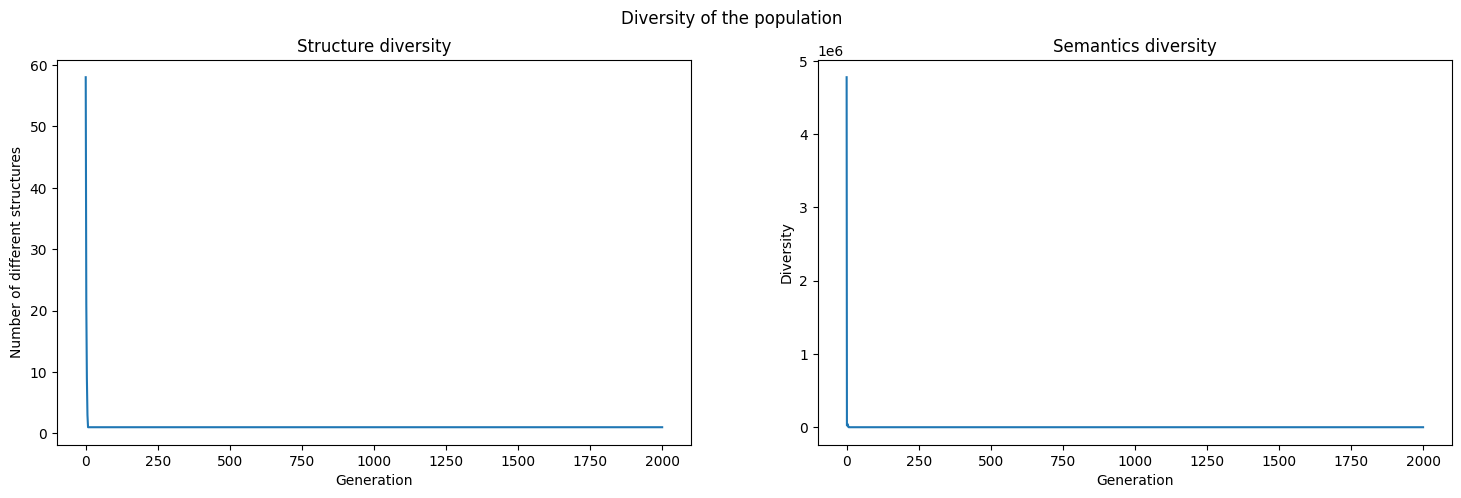

In [12]:
seed = 100

X,y = datasets[3]()
# Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=0)

agelog = LogAge()
divlog = LogDiversity()
early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train,
                    dataset_name='test', test_elite=False, slim_version='SLIM+ABS', # initializer='simple',
                    max_depth=12, init_depth=5, pop_size=100, n_iter=2000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.35, p_struct=0.14, struct_mutation=False, 
                    prob_const=0.06, n_elites=1, selector='tournament', pressure_size=0.5,
                    decay_rate=0.2, p_xo=0, p_struct_xo=0,
                    callbacks=[agelog, divlog, early_stop],
                    depth_distribution='diz', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()

In [ ]:
seed = 100

X,y = datasets[2]()  # AIRFOIL
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.25, seed=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, p_test=0.6, seed=0)
X_train = torch.tensor(scaler_X.fit_transform(X_train))
y_train = torch.tensor(scaler_y.fit_transform(y_train.reshape(-1,1))).flatten()
X_val = torch.tensor(scaler_X.transform(X_val))
y_val = torch.tensor(scaler_y.transform(y_val.reshape(-1,1))).flatten()
X_test = torch.tensor(scaler_X.transform(X_test))
y_test = torch.tensor(scaler_y.transform(y_test.reshape(-1,1))).flatten()

agelog = LogAge()
divlog = LogDiversity()
fitlog = LogFitness()
early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val,
                    dataset_name='test', test_elite=True, slim_version='SLIM+ABS', initializer='simple',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=2000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.45, p_struct=0.3, struct_mutation=False, 
                    prob_const=0.3, n_elites=1, selector='tournament', pressure_size=0.5,
                    decay_rate=0.2, p_xo=0, p_struct_xo=0,
                    callbacks=[agelog, divlog, fitlog, early_stop],
                    depth_distribution='diz', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()
fitlog.plot_fitness()

|       test      |       683       |      0.120      |      0.101      |      0.030      |       126       |        22       |      6.960      |      12.500     |     0.63 (9)    |     1.51 (9)    |     0.0 (30)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
683 iterations completed. Training stopped by callback.
RMSE: tensor(0.1220, dtype=torch.float64)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.187      |       None      |      0.121      |        3        |     3285198     |      4.520      |      4.520      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

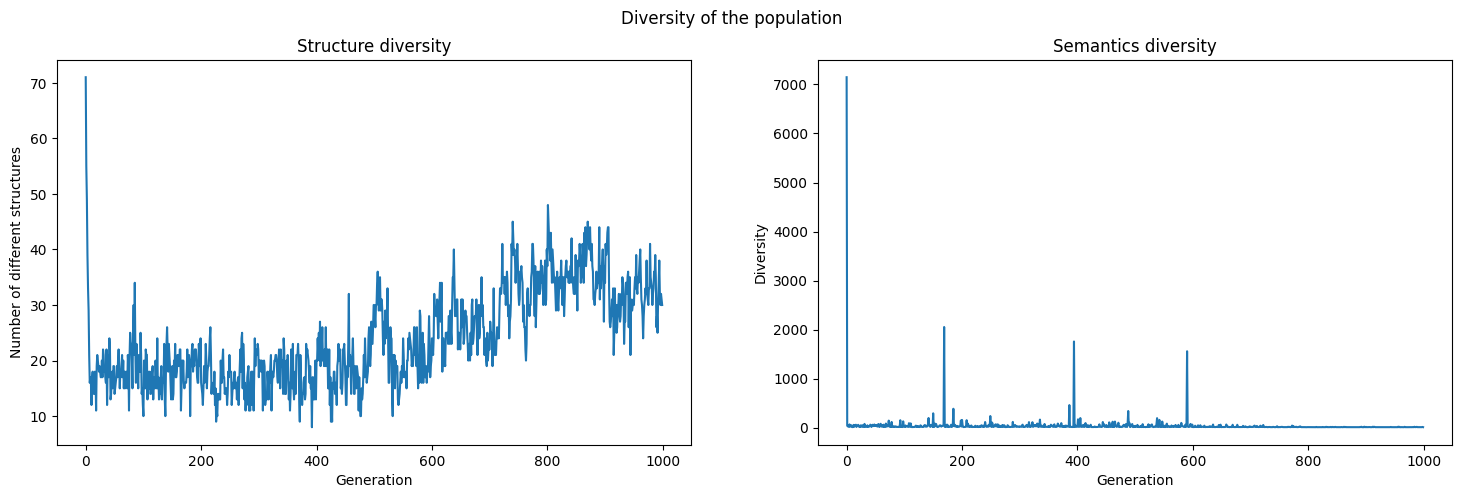

In [4]:
seed = 10

X,y = datasets[2]()  # AIRFOIL
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
X_train = torch.tensor(scaler_X.fit_transform(X_train))
y_train = torch.tensor(scaler_y.fit_transform(y_train.reshape(-1,1))).flatten()
X_test = torch.tensor(scaler_X.transform(X_test))
y_test = torch.tensor(scaler_y.transform(y_test.reshape(-1,1))).flatten()

agelog = LogAge()
divlog = LogDiversity()
early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train, test_elite=False,
                    dataset_name='test', slim_version='SLIM*ABS',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=1000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.45, p_struct=0.25, struct_mutation=True, 
                    prob_const=0.2, n_elites=1, selector='tournament', pressure_size=0.5,
                    decay_rate=0.2, p_xo=0, p_struct_xo=0,
                    callbacks=[agelog, divlog, early_stop],
                    depth_distribution='diz', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()

|       test      |       1000      |      0.116      |       None      |      0.061      |       164       |        7        |      7.960      |      13.010     |    0.73 (13)    |    0.55 (53)    |    0.06 (33)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
RMSE: tensor(0.1250, dtype=torch.float64)


|       test      |       1000      |      0.133      |       None      |      0.078      |       196       |        23       |      2.030      |      12.810     |    0.62 (10)    |    0.88 (42)    |    0.18 (47)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
RMSE: tensor(0.1464, dtype=torch.float64)


In [23]:
count = 0
for num in population.fit:
    count += num.item()

print('Average fitness:', count/len(population.fit))

Average fitness: 684.4216248960993


In [26]:
datasets[2]()[0].shape

torch.Size([1503, 5])

In [27]:
X.shape

torch.Size([100, 1])

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      1.216      |       None      |      0.022      |        3        |        0        |      2.000      |      2.000      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

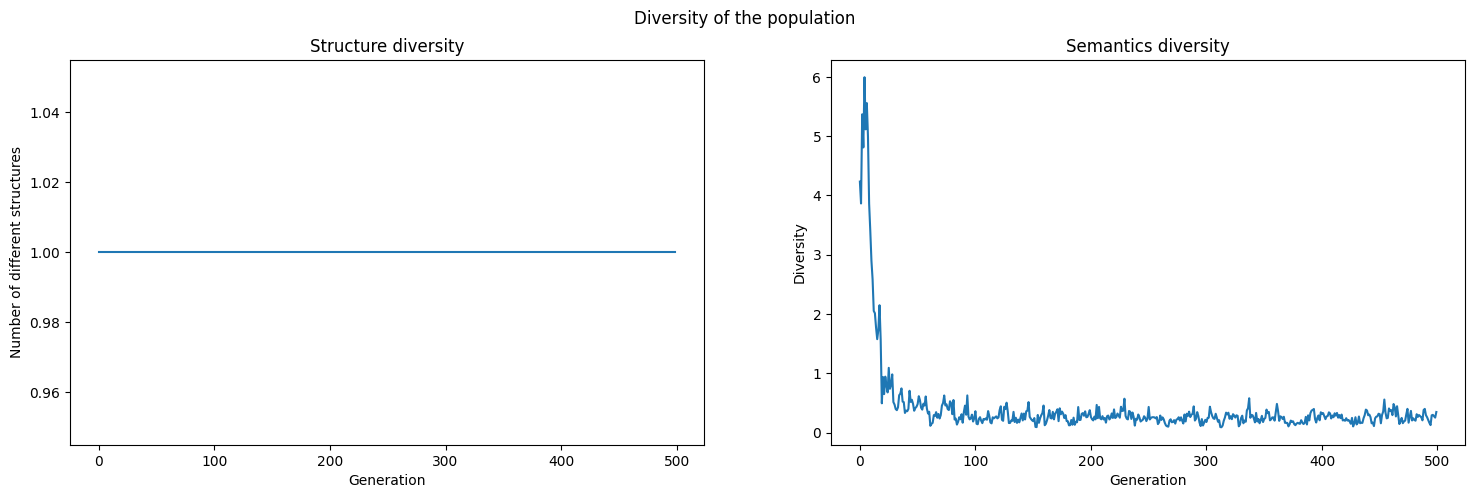

In [35]:
seed = 50
# Create a mock dataset
X = torch.randn(100, 1) + 2
y = -0.1 * X + torch.randn(100, 1) * 0.1
y = y.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, test_elite=False,
                    dataset_name='test', slim_version='SLIM*SIG1', initializer='simple',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=500, seed=seed, verbose=1,
                    p_inflate=0.5, prob_const=0.20, n_elites=1, selector='tournament',
                    decay_rate=0.12, p_xo=0, p_struct_xo=0, struct_mutation=False,
                    callbacks=[agelog, divlog], ms_lower=0, ms_upper=1,
                    depth_distribution='norm', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()

In [38]:
# Use the 10 best individuals to test the ensemble
best_individuals = sorted(population, key=lambda x: x.fitness)[:1]
ensemble_preds = []
for ind in best_individuals:
    ind.version = example_tree.version
    ensemble_preds.append(ind.predict(X_test))
ensemble_preds = np.array(ensemble_preds)
ensemble_preds = torch.tensor(np.mean(ensemble_preds, axis=0))
print('Ensemble RMSE:', rmse(ensemble_preds, y_test))

Ensemble RMSE: tensor(0.2360)


In [9]:
seen_semantics = {}
total_mutations = 0
for ind in population.population:
    semantics = ind.train_semantics[1:]
    for sem_ in semantics:
        total_mutations += 1
        sem = sem_[:2]
        sem = sem.tolist()
        sem = str(sem)
        if sem in seen_semantics:
            seen_semantics[sem] += 1
        else:
            seen_semantics[sem] = 1

seen_semantics = {k: v for k, v in sorted(seen_semantics.items(), key=lambda item: item[1], reverse=True)}
seen_semantics

{'[0.7230196215769629, 0.6002229638017295]': 14,
 '[0.24796877708827428, 0.2479687770882788]': 6,
 '[0.30017995673080594, 0.27233717394464]': 4,
 '[0.3187892641318919, 0.45899144458541086]': 4,
 '[0.0020311404438714963, 0.0008681491847771386]': 4,
 '[0.27158352572178357, 0.3533709826224462]': 2,
 '[1.84063092704671e-05, 2.169333863430165e-05]': 2,
 '[-0.07684937859118623, -0.13131736710802744]': 2,
 '[0.044274846711818534, 0.06370220906924576]': 2,
 '[0.0, 0.0]': 2,
 '[0.0004907770662783563, 0.0013050828354391956]': 2,
 '[0.20576008307512586, 0.09953229934861142]': 1,
 '[0.007425623029711139, 0.012889177956393251]': 1,
 '[0.010917039004823563, 0.01626504675423389]': 1,
 '[0.1088245171169006, 0.050542047254475066]': 1,
 '[-0.5512001167212511, -0.8423733538179834]': 1,
 '[0.975037526555191, 0.0]': 1,
 '[-0.0013744028073024487, -0.08114125153987757]': 1,
 '[0.20078269144766503, 0.20482835891112713]': 1,
 '[0.15695009627917758, 0.22653591229798553]': 1,
 '[-0.24889990972506074, -0.41043121

In [5]:
# Check how many individuals have the most common semantics
most_common_semantics = list(seen_semantics.keys())[0]
count = 0
count_ = 0
for ind in population.population:
    semantics = ind.train_semantics[1:]
    check = True
    for sem_ in semantics:
        sem = sem_[:2]
        sem = sem.tolist()
        sem = str(sem)
        if sem == most_common_semantics:
            count += 1
            break
count

4

In [6]:
population.population[0].structure

[('multiply',
  ('add',
   ('subtract',
    'constant__0.76',
    ('add', ('multiply', 'constant__0.18', 'constant__0.9'), 'constant_0.05')),
   ('multiply',
    ('add',
     ('divide', ('add', 'x2', 'x4'), ('divide', 'x4', ('divide', 'x3', 'x3'))),
     ('divide', ('add', 'x4', 'constant_0.83'), 'x1')),
    ('multiply', 'x0', 'x4'))),
  'constant__0.67')]

In [163]:
# Which ones dont have 
for ind in population.population:
    semantics = ind.train_semantics[1:]
    for sem_ in semantics:
        sem = sem_[:5]
        sem = sem.tolist()
        sem = str(sem)
        if sem != most_common_semantics:
            print(sem)
            break

[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[1.1213422461523217, 1.0826020837220371, 1.107485585333633, 1.1092573946161297, 1.0144084577210426]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.543607950

In [40]:
preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))
print('Nodes:', example_tree.nodes_count)

example_tree_ = simplify_individual(example_tree, y_val, X_val, threshold=0.05)
preds_ = example_tree_.predict(X_test)
print('RMSE:', rmse(preds_, y_test))
print('Nodes:', example_tree_.nodes_count)

RMSE: tensor(0.1206, dtype=torch.float64)
Nodes: 124
RMSE: tensor(0.1289, dtype=torch.float64)
Nodes: 17


In [41]:
example_tree_.structure

[(np.str_('divide'),
  ('subtract',
   ('multiply',
    ('add', 'constant_0.4', ('divide', 'x1', 'x2')),
    ('multiply', ('multiply', 'x4', 'x2'), ('divide', 'x0', 'x4'))),
   'constant_0.41'),
  'constant__0.61')]

In [ ]:
pip install tensorflow

In [49]:
# Try a NN with the same architecture
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(10, input_dim=5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=250)])
preds = model.predict(X_test)
print('RMSE:', rmse(torch.tensor(preds).flatten(), y_test))

ModuleNotFoundError: No module named 'tensorflow'

In [25]:
example_tree_.structure[0]
simplified = example_tree_

In [8]:
def get_indices_with_levels_mod(tree):
    """
    Get all indices that can be used to access valid subtrees or terminal nodes in a tree,
    along with their corresponding levels in the tree.

    Parameters
    ----------
    tree : tuple
        The root node of the tree.

    Returns
    -------
    list
        A list of tuples, each containing an index path and its corresponding level in the tree.
    """
    
    def traverse(sub_tree, path=(), level=0):
        indices_with_levels = []
        
        # If not tuple 
        if not isinstance(sub_tree, tuple):
            indices_with_levels.append((path, level))

        # If tuple, separate
        else:
            indices_with_levels.append((path, level)) if path != () else None
            op, left, right = sub_tree  
            # Can substitute the left or right
            indices_with_levels.extend(traverse(left, path + (1,), level + 1))
            indices_with_levels.extend(traverse(right, path + (2,), level + 1))

        return indices_with_levels
    
    return [((), (0))] + traverse(tree)

def structure_mutation(FUNCTIONS, TERMINALS, CONSTANTS, depth_dist="norm"):
    """
    Generate a function for the structure mutation.

    Parameters
    ----------
    FUNCTIONS : dict
        The dictionary of functions used in the mutation.
    TERMINALS : dict
        The dictionary of terminals used in the mutation.
    CONSTANTS : dict
        The dictionary of constants used in the mutation.
    depth_dist : str, optional
        Distribution to choose the depth of the new tree (default: "norm"), options: "norm", "exp", "uniform", "max", "diz"
        If diz is chosen, then we can only decrease/increase the depth by 1 or not change it at all.
    Returns
    -------
    
    Callable
        A structure mutation function (`structure`).
        
    """
    def structure(individual,
                        X,
                        max_depth=8,
                        p_c=0.1,
                        X_test=None,
                        grow_probability=1,
                        reconstruct=True, 
                        decay_rate=0.2,
                        **args,
    ):
        """
        Perform a mutation on a given Individual by changing the main structure of the tree.

        Parameters
        ----------
        individual : Individual
            The Individual to be mutated.
        X : torch.Tensor
            Input data for calculating semantics.
        max_depth : int, optional
            Maximum depth for generated trees (default: 8).
        p_c : float, optional
            Probability of choosing constants (default: 0.1).
        p_prune : float, optional
            Probability of pruning the tree (default: 0.5).
        X_test : torch.Tensor, optional
            Test data for calculating test semantics (default: None).
        grow_probability : float, optional
            Probability of growing trees during mutation (default: 1). 
            If changed, trees will be completely replaced during mutation more often.
        replace_probability : float, optional
            Probability of replacing the main tree during mutation (default: 0.1).
        X_test : torch.Tensor, optional
            Test data for calculating test semantics (default: None).
        exp_decay : bool, optional
            Flag to indicate whether exponential decay should be used to soften the mutation (default: False).
        reconstruct : bool
            Whether to store the Individuals structure after mutation.

        Returns
        -------
        Individual
            The mutated individual
        """

        indices_with_levels = get_indices_with_levels_mod(individual.structure[0])
        valid_indices_with_levels = [(index, level) for index, level in indices_with_levels if max_depth - len(index) >= 2]

        if not valid_indices_with_levels:
            raise ValueError("No valid indices satisfy the condition max_depth - len(index) >= 2")

        valid_indices, valid_levels = zip(*valid_indices_with_levels)

        if depth_dist == "diz": 
            # Can only choose either an index with max depth, or the one before
            individual_depth = individual.depth_collection[0]
            if random.random() < 0.5:
                chosen_level = individual_depth - 2
                depth = random.choice([1, 2, 3])
            else:
                chosen_level = individual_depth - 1
                depth = random.choice([1, 2])

            valid_indices = [index for index, level in valid_indices_with_levels if level == chosen_level]
            random_index = random.choice(valid_indices)

        else:
            probs = exp_decay_prob(max(valid_levels) + 1, decay_rate=decay_rate)
            level_probs = [probs[level] for level in valid_levels]
            random_index = random.choices(valid_indices, weights=level_probs)[0]

            if depth_dist == "norm":
                depth = choose_depth_norm(max_depth, random_index, mean=None, std_dev=None)
                
            else:
                depth = max_depth - len(random_index)   
                depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
                
                if depth_dist == "exp":
                    probs = exp_decay_prob(len(depths), decay_rate=decay_rate)
                    depth = random.choices(depths, weights=probs)[0]    
                    
                elif depth_dist == "uniform":
                    depth = random.choice(depths)
                    
                elif depth_dist == "max":
                    depth = depths[-1]
                            
        
        # If just a node is selected
        if depth == 1:
            if random.random() < p_c:
                new_block = random.choice(list(CONSTANTS.keys()))
            else:
                new_block = random.choice(list(TERMINALS.keys()))
            
            # Swap the subtree in the main tree
            new_structure = swap_sub_tree(individual.structure[0], new_block, list(random_index))
                        
        else:
            rt = get_random_tree(
            depth,
            FUNCTIONS,
            TERMINALS,
            CONSTANTS,
            inputs=X,
            p_c=p_c,
            grow_probability=grow_probability,
            logistic=False,
        )         

            # Swap the subtree in the main tree
            new_structure = swap_sub_tree(individual.structure[0], rt.structure, list(random_index))
    
        # Create the new block
        new_block = Tree(structure=new_structure,
                            train_semantics=None,
                            test_semantics=None,
                            reconstruct=True)
        
        new_block.calculate_semantics(X)            
        
        # Create the offspring individual
        if X_test is not None:
            new_block.calculate_semantics(X_test, testing=True, logistic=False)
            
        offs = Individual(
            collection=[new_block, *individual.collection[1:]],
            train_semantics=torch.stack(
                [
                    new_block.train_semantics,
                    *individual.train_semantics[1:],
                ]   
            ),
            test_semantics=(
                torch.stack(
                    [
                        new_block.test_semantics,
                        *individual.test_semantics[1:],
                    ]
                )
                if X_test is not None
                else None
            ),
            reconstruct=reconstruct
        )

        # computing offspring attributes
        offs.size = individual.size
        offs.nodes_collection = [new_block.nodes,*individual.nodes_collection[1:]]
        offs.nodes_count = sum(offs.nodes_collection) + offs.size - 1

        offs.depth_collection = [new_block.depth, *individual.depth_collection[1:]]
        offs.depth = max(offs.depth_collection) + offs.size - 1
        offs.version = individual.version

        offs.id = individual.id

        return offs    
    
    return structure

In [12]:
simplified.depth_collection[0]

3

In [11]:
struct_mut = structure_mutation(FUNCTIONS=simplified.collection[1].FUNCTIONS, 
                                CONSTANTS=simplified.collection[1].CONSTANTS,
                                TERMINALS=simplified.collection[1].TERMINALS,
                                depth_dist='exp')

rmse_vals = []
size_vals = []
current_best_score = 0.5
current_best = None

for i in range(5000):
    simplified_mut = struct_mut(simplified, X=X_train, max_depth=7, decay_rate=2)
    # simplified_mut = simplify_individual(simplified_mut, y_val, X_val, threshold=0.01)
    simplified_mut.version = simplified.version
    preds_ = simplified_mut.predict(X_test)
    rmse_ = rmse(preds_, y_test)
    if rmse_ < current_best_score:
        current_best_score = rmse_
        current_best = simplified_mut
        print('New best:', rmse_)
        print(simplified_mut.structure[0])
    rmse_vals.append(rmse_)
    size_vals.append(simplified_mut.nodes_collection[0])

New best: tensor(0.4806, dtype=torch.float64)
('multiply', ('add', 'x2', 'x3'), 'constant_0.37')
New best: tensor(0.4568, dtype=torch.float64)
('multiply', ('add', 'x1', ('subtract', 'x1', ('multiply', ('subtract', 'x1', 'x1'), 'x3'))), 'constant_0.37')
New best: tensor(0.3165, dtype=torch.float64)
('multiply', ('add', 'x2', 'x1'), 'constant_0.37')
New best: tensor(0.2693, dtype=torch.float64)
('multiply', ('divide', 'x2', 'x2'), 'constant_0.37')
New best: tensor(0.2232, dtype=torch.float64)
('multiply', ('subtract', 'constant_0.75', 'x4'), 'constant_0.37')
New best: tensor(0.1469, dtype=torch.float64)
('multiply', 'constant_0.7', ('divide', 'constant_0.32', ('divide', 'x0', 'x0')))
New best: tensor(0.1327, dtype=torch.float64)
('multiply', ('divide', 'constant_0.77', 'constant_0.97'), 'constant_0.37')


In [17]:
preds = current_best.predict(X_test)
print('RMSE:', rmse(preds, y_test))
print('Nodes:', current_best.nodes_count)

current_best_ = simplify_individual(current_best, y_train, X_train, threshold=0.01)
preds_ = current_best_.predict(X_test)
print('RMSE:', rmse(preds_, y_test))
print('Nodes:', current_best_.nodes_count)

RMSE: tensor(0.1280, dtype=torch.float64)
Nodes: 124
RMSE: tensor(0.1280, dtype=torch.float64)
Nodes: 124


RMSE: tensor(0.1158, dtype=torch.float64) </br>
('multiply', 'constant_0.7', ('add', 'x1', 'constant__0.26'))

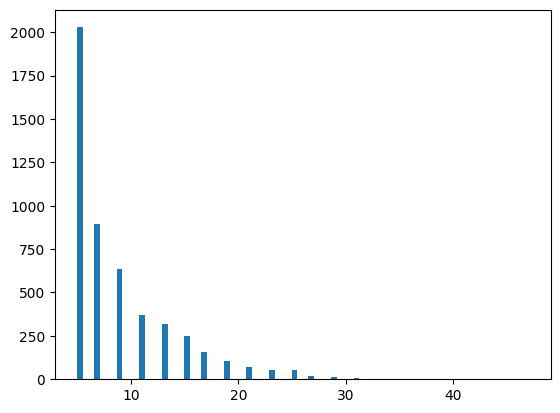

In [113]:
# Plot the distribution of the size of the trees
plt.hist(size_vals, bins=80)
plt.show()

In [114]:
np.min(size_vals)

np.int64(5)

In [80]:
rmse_vals = np.array(rmse_vals)
print('Mean RMSE:', np.min(rmse_vals))
best_id = np.argmin(rmse_vals)
print('Best ID:', best_id)

Mean RMSE: 0.12632628496653595
Best ID: 929


In [40]:
seed = 0

X,y = datasets[13]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, # X_test=X_test, y_test=y_test,
                    dataset_name='test', test_elite=False, slim_version='SLIM*SIG1',
                    max_depth=12, init_depth=4, pop_size=20, n_iter=2000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.4, p_struct=0.2, # selector='e_lexicase',
                    struct_mutation=True, decay_rate=0.1, p_xo=0, type_structure_mutation='new', callbacks=[agelog, divlog],
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.409      |       None      |      0.006      |        3        |       258       |      2.950      |      2.950      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

best 0.243070

In [2]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

In [ ]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

# Example usage
max_depth = 22
random_index = [1, 2,2,2,2,2]  # Example index

depths = []
for i in range(10000):
    depths.append(choose_depth(max_depth, random_index))
    
plt.hist(depths, bins=np.arange(1, max_depth + 1) - 0.5, rwidth=0.8)
plt.show()

In [2]:
seed = 0

X,y = datasets[10]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, # X_test=X_test, y_test=y_test,
                    dataset_name='test', test_elite=False, slim_version='SLIM*SIG1',
                    max_depth=22, init_depth=10, pop_size=100, n_iter=100, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.4, p_struct=0.2, selector='e_lexicase',
                    struct_mutation=False, decay_rate=0.1, p_xo=0, type_structure_mutation='new', callbacks=[agelog, divlog],
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.234      |       None      |      0.213      |        3        |    2128770183   |      4.910      |      4.910      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

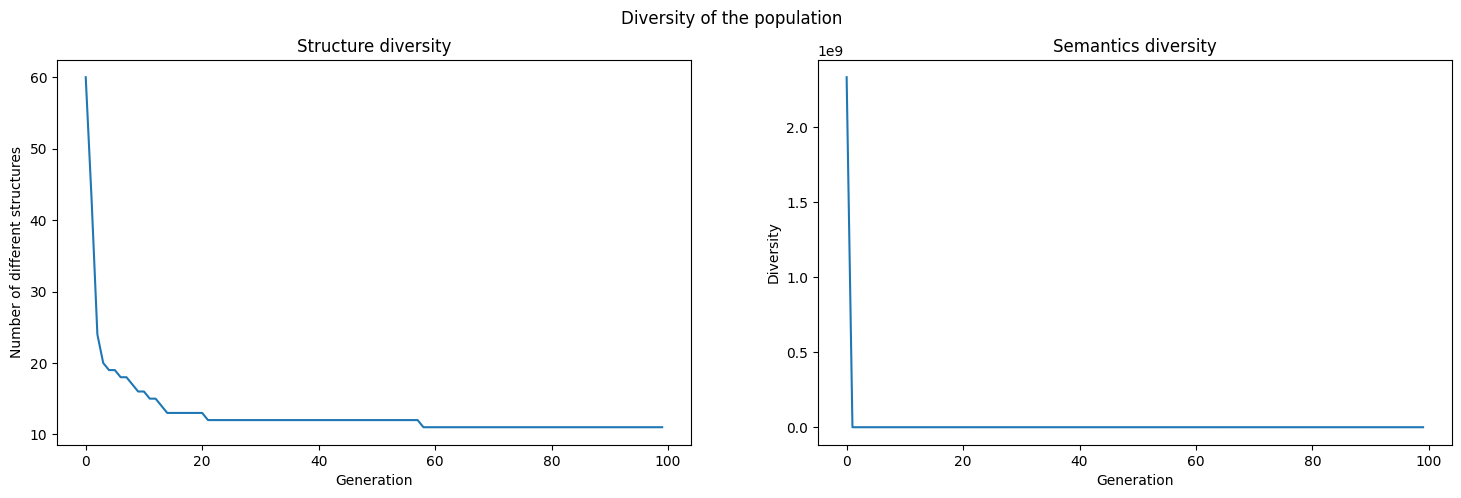

In [3]:
divlog.plot_diversity()

In [94]:
# Check the fitness for each individual
fitnesses = []

for tree in population.population:
    preds = tree.predict(X_test)
    fitnesses.append(rmse(preds, y_test))

# Get the 10 best fitnesses from the fitnesses list 
best_fitnesses = sorted(fitnesses)[:10]

# Get the ids 
best_ids = [fitnesses.index(i) for i in best_fitnesses]

ten_best = [population.population[i] for i in best_ids]

# Create a dataset and predict a linear model for the stacking ensemble
X_train_stacking = torch.zeros((X_train.shape[0], size))
X_test_stacking = torch.zeros((X_test.shape[0], size))

for i, tree in enumerate(ten_best):
    tree.version = 'SLIM*SIG1'
    X_train_stacking[:, i] = tree.predict(X_train)
    X_test_stacking[:, i] = tree.predict(X_test)
    
# Train a linear model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_stacking, y_train)

preds = lr.predict(X_test_stacking)
print('RMSE:', rmse(torch.tensor(preds), y_test))

RMSE: tensor(0.1013, dtype=torch.float64)


In [ ]:
constants = example_tree.collection[0].CONSTANTS
functions = example_tree.collection[0].FUNCTIONS
terminals = example_tree.collection[0].TERMINALS
depths = []

for i in range(10000):
    dep = choose_depth(14, [1,1,1,1])
    # dep = random.choice(np.arange(1, 14 + 1))
    # probs = exp_decay_prob(14, 0.3)
    # dep = random.choices(np.arange(1, 14 + 1), weights=probs, k=1)[0]
    if dep == 1:
        depths.append(1)
    else:
        depth = get_random_tree(max_depth=dep, 
                        FUNCTIONS=functions,
                        TERMINALS=terminals,
                        CONSTANTS=constants,
                        p_c=0.1).depth
        
        depths.append(depth)

plt.hist(depths, bins=np.arange(1, 14 + 1) - 0.5, rwidth=0.8)
plt.show()

In [15]:
indices_with_levels = get_indices_with_levels(example_tree.structure[0])
valid_indices_with_levels = [(index, level) for index, level in indices_with_levels if 22 - len(index) >= 2]


valid_indices, valid_levels = zip(*valid_indices_with_levels)
probs = exp_decay_prob(max(valid_levels) + 1, decay_rate=0.2)
level_probs = [probs[level] for level in valid_levels]
random_index = random.choices(valid_indices, weights=level_probs)[0]

In [4]:
indices_list = get_indices_with_levels(example_tree.structure[0])

In [ ]:
get_indices_with_levels(example_tree.structure[0])

In [ ]:
exp_decay_prob(5, decay_rate=0.3)

In [ ]:
decay_prob

In [17]:
counts_dict = {}

for i in range(10000):
    random_index = random.choices(indices_list, weights=decay_prob)[0]
    if random_index in counts_dict:
        counts_dict[random_index] += 1
    else:
        counts_dict[random_index] = 1

In [ ]:
counts_dict